<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Разбейте-данные-на-обучающую-и-валидационную-выборки-в-соотношении-75:25." data-toc-modified-id="Разбейте-данные-на-обучающую-и-валидационную-выборки-в-соотношении-75:25.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.</a></span></li><li><span><a href="#Обучите-модель-и-сделайте-предсказания-на-валидационной-выборке." data-toc-modified-id="Обучите-модель-и-сделайте-предсказания-на-валидационной-выборке.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучите модель и сделайте предсказания на валидационной выборке.</a></span></li><li><span><a href="#Средний-запас-предсказанного-сырья-и-RMSE-модели." data-toc-modified-id="Средний-запас-предсказанного-сырья-и-RMSE-модели.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Средний запас предсказанного сырья и RMSE модели.</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.\
Нужно решить, где бурить новую скважину.\
Шаги для выбора локации обычно такие:
 - В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
 - Строят модель для предсказания объёма запасов в новых скважинах;
 - Выбирают скважины с самыми высокими оценками значений;
 - Определяют регион с максимальной суммарной прибылью отобранных скважин.

**Описание данных:**\
id — уникальный идентификатор скважины;\
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);\
product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**\
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
TOTAL_BUDGET = 10000000000 # общие затраты на разработку в регионе
INCOME_1000 = 450000 # доход с единицы продукта(1000 баррелей)
INCOME_1 = 450 # доход с 1 барреля
OIL_WELL = 200 # количество скважин
PROBABILITY_OF_LOSSES = 0.025 # вероятность убытков

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
def information (data):
    display(data.head(10))
    print('\033[1m'+'Общая информация о данных:'+'\033[0m','\n')
    print(data.info(),'\n')
    print('\033[1m'+'Наличие пропусков в данных:'+'\033[0m','\n')
    print(data.isna().sum(),'\n')
    print('\033[1m'+'Наличие явных дубликатов:'+'\033[0m','\n')
    print(data.duplicated().sum(),'\n')
    print('\033[1m'+'Описательная статистика'+'\033[0m','\n')
    display(data.describe())
    print('\033[1m'+'Корреляция между признаками'+'\033[0m','\n')
    display(data.corr())

In [5]:
information(geo_data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Наличие пропусков в данных: 

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Наличие явных дубликатов: 

0 

Описательная статистика 



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Корреляция между признаками 



,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


**Данные региона №0** впорядке: пропуски и дубликаты отсутствуют, тип данных соответствующий, наименование столбцов правильное.\
Целевой признак product имеет положительную корреляцию 0,48 с признаком f2

In [6]:
information(geo_data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Наличие пропусков в данных: 

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Наличие явных дубликатов: 

0 

Описательная статистика 



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Корреляция между признаками 



,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


**Данные региона №1** впорядке: пропуски и дубликаты отсутствуют, тип данных соответствующий, наименование столбцов правильное.\
Целевой признак product имеет очень сильную положительную корреляцию 0,99 практически 1 с признаком f2.

In [7]:
information(geo_data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

Наличие пропусков в данных: 

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Наличие явных дубликатов: 

0 

Описательная статистика 



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Корреляция между признаками 



,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Данные региона №2** впорядке: пропуски и дубликаты отсутствуют, тип данных соответствующий, наименование столбцов правильное.\
Целевой признак product так же как и в geo_data_0 имеет положительную корреляцию 0,44 с признаком f2.

Признак id носит уникальный характер и никак не влияет на целевой признак product, удалим его.

In [8]:
geo_data_0 = geo_data_0.drop(['id'],axis=1)
geo_data_1 = geo_data_1.drop(['id'],axis=1)
geo_data_2 = geo_data_2.drop(['id'],axis=1)

## Обучение и проверка модели

### Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.

In [9]:
features_geo_0 = geo_data_0.drop(['product'], axis=1)
target_geo_0 = geo_data_0['product']


features_geo_1 = geo_data_1.drop(['product'], axis=1)
target_geo_1 = geo_data_1['product']


features_geo_2 = geo_data_2.drop(['product'], axis=1)
target_geo_2 = geo_data_2['product']

In [10]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_geo_0, target_geo_0, 
                                                    test_size=0.25, 
                                                    random_state=12345
                                                    )

In [11]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_geo_1, target_geo_1, 
                                                    test_size=0.25, 
                                                    random_state=12345
                                                    )


In [12]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_geo_2, target_geo_2, 
                                                    test_size=0.25, 
                                                    random_state=12345
                                                    )

### Обучите модель и сделайте предсказания на валидационной выборке.

In [13]:
model = LinearRegression()
def predict_valid (features_train,target_train,features_valid):
    model.fit(features_train, target_train)
    predicted_valid = pd.Series(model.predict(features_valid),index=target_valid_0.index)
    return predicted_valid

In [14]:
predict_valid_0 = predict_valid(features_train_0,target_train_0,features_valid_0)
predict_valid_1 = predict_valid(features_train_1,target_train_1,features_valid_1)
predict_valid_2 = predict_valid(features_train_2,target_train_2,features_valid_2)

In [15]:
predict = [predict_valid_0,predict_valid_1,predict_valid_2]
target = [target_valid_0, target_valid_1, target_valid_2]

### Средний запас предсказанного сырья и RMSE модели.

In [16]:
for i in range(len(predict)):
  
    print(f'Регион {i}')
    print(f'Cредний запас предсказанного сырья {predict[i].mean()}')
    rmse = mean_squared_error(target[i], predict[i],squared=False)
    print('RMSE модели', rmse, '\n')

Регион 0
Cредний запас предсказанного сырья 92.59256778438035
RMSE модели 37.5794217150813 

Регион 1
Cредний запас предсказанного сырья 68.72854689544602
RMSE модели 0.8930992867756165 

Регион 2
Cредний запас предсказанного сырья 94.96504596800489
RMSE модели 40.02970873393434 



Наименьшая ошибка у модели, обученной на данных **Региона 1**, близка к нулю, ошибки на двух других регионах превышают данный показатель почти в 40 раз. Предполагаю, что такие результаты связаны с тем, что в регионе 1, наблюдалась сильная корреляция целевого признака с признаком f2(близка к 1)

## Подготовка к расчёту прибыли

In [17]:
#Рассчитаем затраты на разработку одной скважины
budget_one_oil_well = TOTAL_BUDGET/OIL_WELL
#Рассчитаем необходимый объем скважины для безубыточной разработки
oil_well_volume = budget_one_oil_well / INCOME_1000
print(f'Затраты на разработку одной скважины : {budget_one_oil_well }')
print('Необходимый объем скважины для безубыточной разработки :  {:.3f} тысяч баррелей'.format(oil_well_volume))

Затраты на разработку одной скважины : 50000000.0
Необходимый объем скважины для безубыточной разработки :  111.111 тысяч баррелей


In [18]:
target_geo_0.mean(), target_geo_1.mean(), target_geo_2.mean()

(92.50000000000001, 68.82500000000002, 95.00000000000004)

Ни один регион по предсказанному среднему запасу сырья не удовлетворяет условию для безубыточной разработки в объеме 111,111 тыс.баррелей.\
Средний объем предсказанного сырья рассчитан на основании 25 000 точек, из которых в результате надо выбрать 200. В результате,  среди этих скважин могут быть скважины с достаточным и недостаточным запасом сырья.
    
Имеено техника "Bootstrap" позволяет оценить риск убытков при случайным отборе точек. 1000 раз отбирая случайным образом точки, считаем какой % случаев принесет убытки. 

## Расчёт прибыли и рисков 

In [19]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    selected_sum = selected.sum()
    return INCOME_1000 * selected_sum  - TOTAL_BUDGET

In [24]:
def risk (target_valid,predict_valid,name,color):
    state = np.random.RandomState(12345)
    values = [] 
    count_negative_profit = 0
    for j in range(1000):
        target_subsample = target_valid.sample(500,replace=True, random_state=state)
        probs_subsample = predict_valid [target_subsample.index]  
        revenue_2 = revenue(target_subsample,probs_subsample,OIL_WELL)
        values.append(revenue_2)
        if revenue_2 < 0:
            count_negative_profit+=1
    values = pd.Series(values)
    lower = values.quantile(PROBABILITY_OF_LOSSES)
    upper = values.quantile(0.975)


    mean = values.mean()

    print('\033[94m'+'—'*80)
    print(name)
    print("Средняя выручка:", mean)
    print('95% доверительный интервал:({:.2f} ; {:.2f})'.format(lower, upper))
    print('Риск убытков: {:.2%}'.format(count_negative_profit / 1000))
    print('\033[94m'+'—'*80)
    
    
    
    plt.figure(figsize=(13,8))
    sns.distplot(values, color=color)
    plt.axvline(lower, color='red')
    plt.axvline(mean, color='black',linestyle=':')
    plt.axvline(upper, color='red')
    plt.title(f'Выручка {name}',fontsize=22)
    plt.xlabel('выручка в рублях')
    plt.ylabel('количество скважин')

————————————————————————————————————————————————————————————————————————————————
Регион 0
Средняя выручка: 425938526.91059244
95% доверительный интервал:(-102090094.84 ; 947976353.36)
Риск убытков: 6.00%
————————————————————————————————————————————————————————————————————————————————


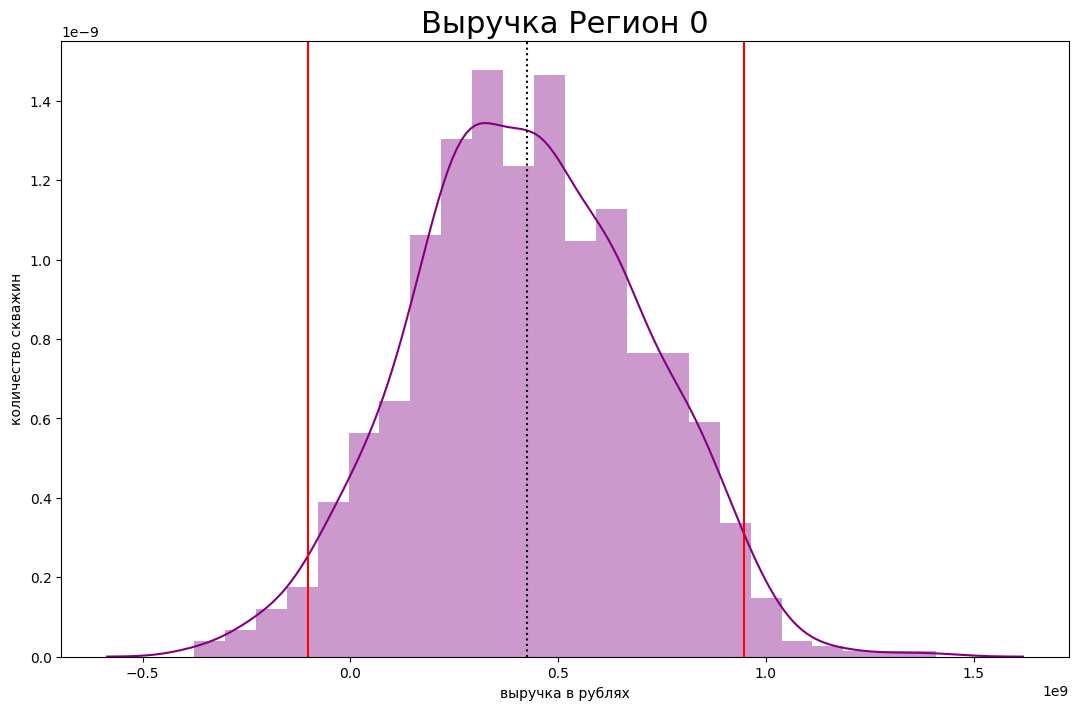

In [25]:
risk(target_valid_0,predict_valid_0,'Регион 0','purple')

————————————————————————————————————————————————————————————————————————————————
Регион 1
Средняя выручка: 515222773.4432899
95% доверительный интервал:(68873225.37 ; 931547591.26)
Риск убытков: 1.00%
————————————————————————————————————————————————————————————————————————————————


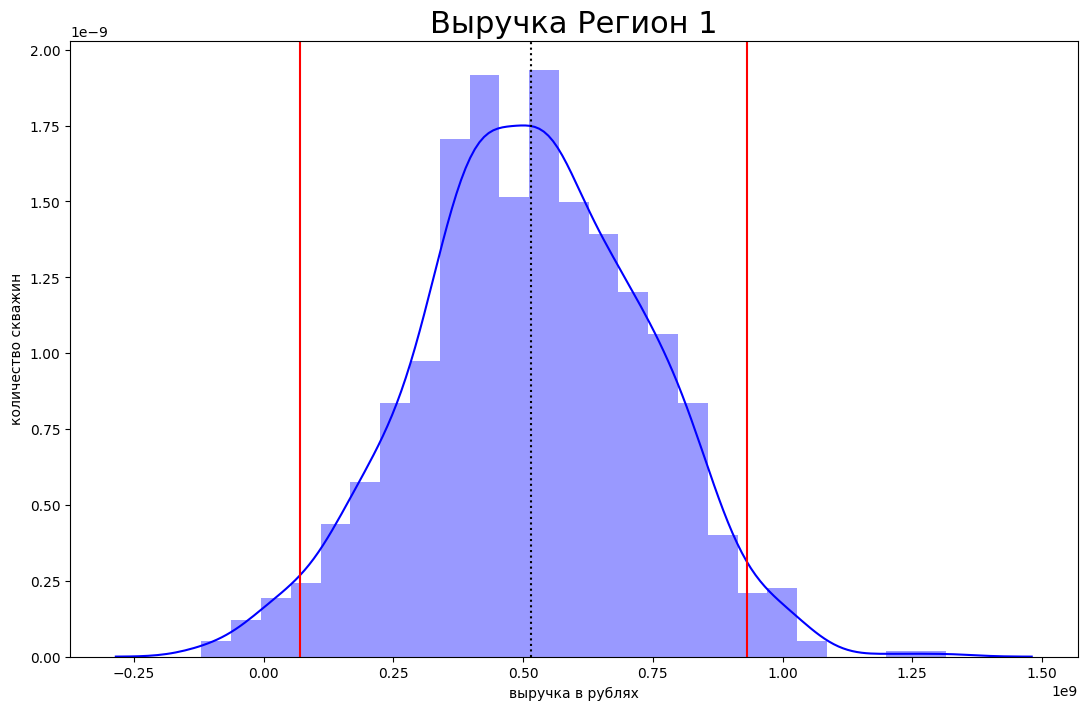

In [26]:
risk(target_valid_1,predict_valid_1,'Регион 1','blue')

————————————————————————————————————————————————————————————————————————————————
Регион 2
Средняя выручка: 435008362.7827556
95% доверительный интервал:(-128880547.33 ; 969706954.18)
Риск убытков: 6.40%
————————————————————————————————————————————————————————————————————————————————


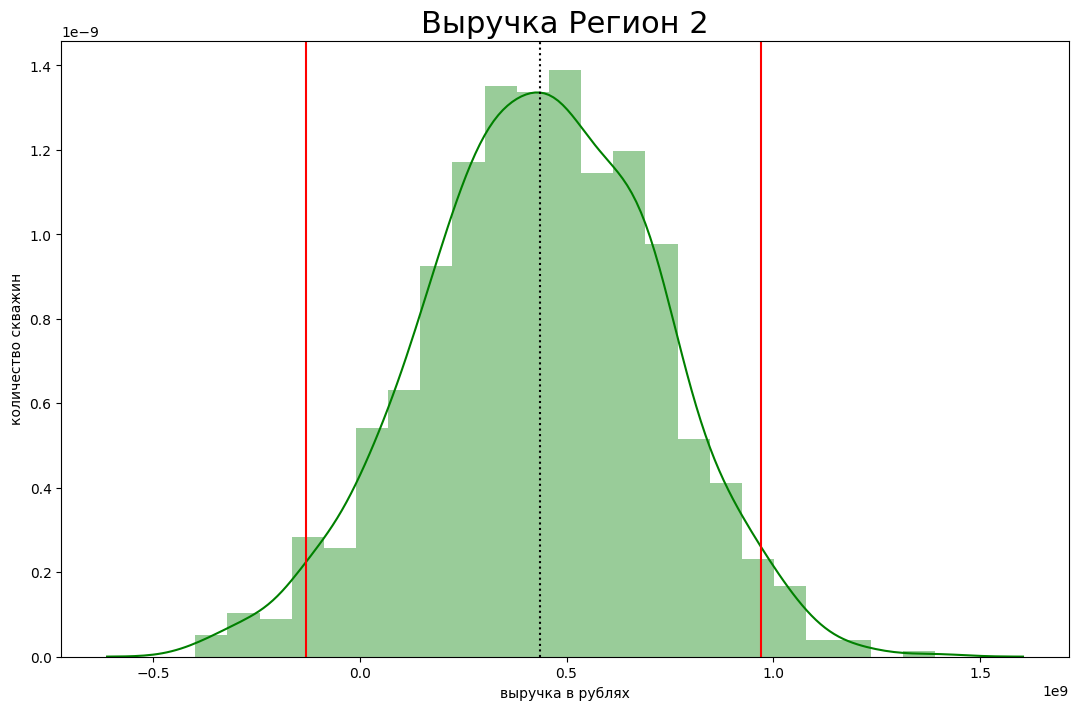

In [27]:
risk(target_valid_2,predict_valid_2,'Регион 2','green')

## Вывод

Согласно условию задачи после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5% и среди них выбирать регион с наибольшей средней прибылью. Этому условию **соответствует только Регион №1**, где вероятность риска равна 1% и средняя прибыль составляет более 515 млн.рублей.\
Так же предсазания модели лучше всего работают на данных Региона№1, ошибка модели составляет 0,89.